In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from cv2 import imread
import os
import pandas as pd
import xml.etree.ElementTree as ET
import seaborn as sns

In [2]:
root_dir = "../results/impurities_bbox_test/"
bbox_dir = "../datasets/impurities_bbox_test/bbox"

def get_bbox(xml_f):
    root = ET.parse(xml_f).getroot()
    boxes = []
    for obj in root.findall("object/bndbox"):
        xmin = int(obj.find("xmin").text)
        xmin = np.clip(xmin - 88, 0, 1023)
        xmax = int(obj.find("xmax").text)
        xmax = np.clip(xmax - 88, 0, 1023)
        ymin = int(obj.find("ymin").text)
        ymin = np.clip(ymin - 88, 0, 1023)
        ymax = int(obj.find("ymax").text)
        ymax = np.clip(ymax - 88, 0, 1023)
        boxes.append((xmin, xmax, ymin, ymax))
    return boxes

def get_inside_boxes(arr, boxes, bg_mask):
    arrays = []
    arr[bg_mask] = np.nan
    for xmin, xmax, ymin, ymax in boxes:
        arrays.append(arr[ymin:ymax, xmin:xmax].reshape(-1))
    result = np.concatenate(arrays, axis=0)
    return result[~np.isnan(result)]

def get_outside_boxes(arr, boxes, bg_mask):
    arr = arr.copy()
    arr[bg_mask] = np.nan
    for xmin, xmax, ymin, ymax in boxes:
        arr[ymin:ymax, xmin:xmax] = np.nan
    arr = arr.reshape(-1)
    arr_out = arr[~np.isnan(arr)]
    return arr_out

def background_truth(truth_arr):
    return truth_arr <= 10


gather_uncertainty = []
gather_error = []
is_inside = []

for bbox_f in os.listdir(bbox_dir):
    id = bbox_f.split(".")[0]
    src_f = f"source_{id}.png.png"
    truth_f = f"tgt_{id}.png.png"
    uncer_f = f"uncertainty_{id}.png.npy"
    err_f = f"error_{id}.png.npy"
    uncer_arr = np.load(os.path.join(root_dir, uncer_f))[0, :, :].astype(float)
    err_arr = np.load(os.path.join(root_dir, err_f))[0, :, :].astype(float)
    truth_arr = imread(os.path.join(root_dir, truth_f))[:, :, 0]
    bg_mask = background_truth(truth_arr)
    boxes = get_bbox(os.path.join(bbox_dir, bbox_f))
    
    color = (255, 0, 0)
    img = (uncer_arr * 1500).clip(0, 255).astype(np.uint8) #imread(os.path.join(root_dir, src_f))
    for box in boxes:
        img = cv2.rectangle(img, (box[0], box[2]), (box[1], box[3]), color, 2)
    out_f = f"./uncertainty_bbox/uncertainty_bbox_{id}.png"
    cv2.imwrite(out_f, img)
    #plt.show()
    #break

    inside_uncer = get_inside_boxes(uncer_arr, boxes, bg_mask)
    gather_uncertainty.append(inside_uncer)
    inside_err = get_inside_boxes(err_arr, boxes, bg_mask)
    gather_error.append(inside_err)
    assert len(inside_uncer) == len(inside_err)
    is_inside.append([1] * len(inside_uncer))

    outside_uncer = get_outside_boxes(uncer_arr, boxes, bg_mask)[::50]
    gather_uncertainty.append(outside_uncer)
    outside_err = get_outside_boxes(err_arr, boxes, bg_mask)[::50]
    gather_error.append(outside_err)
    assert len(outside_uncer) == len(outside_err)
    is_inside.append([0] * len(outside_uncer))

gather_uncertainty = np.concatenate(gather_uncertainty, axis=0)
gather_error = np.concatenate(gather_error, axis=0)
is_inside = np.concatenate(is_inside, axis=0)

plot_df = pd.DataFrame({"Uncertainty": gather_uncertainty, "Error": gather_error, "Is_inside": is_inside})
plot_df["Uncertainty_bin"] = pd.cut(plot_df["Uncertainty"], bins=20)
plot_df_bin = plot_df.groupby(["Is_inside", "Uncertainty_bin"]).agg({"Uncertainty": "mean", "Error": "std"})

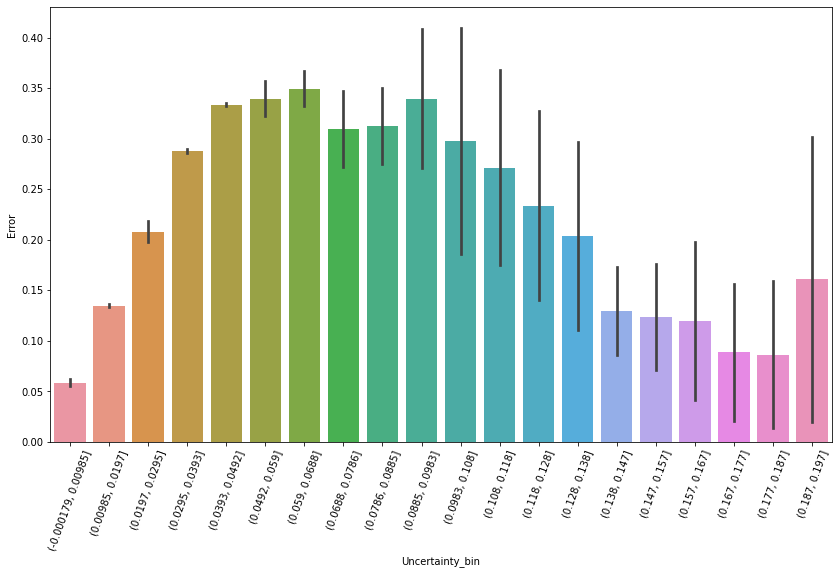

In [45]:
plt.rcParams["figure.figsize"] = (14, 8)
sns.barplot(x="Uncertainty_bin", y="Error", data=plot_df_bin.reset_index())
_ = plt.xticks(rotation=70)

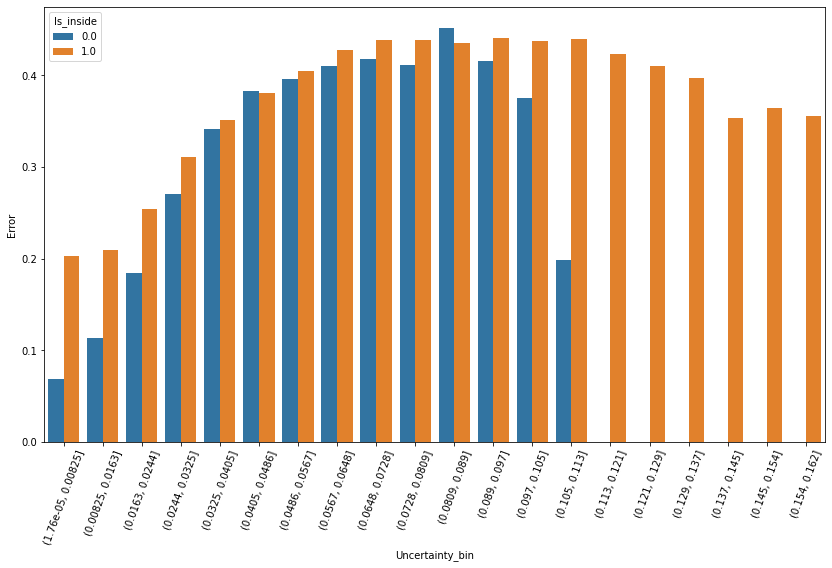

In [18]:
plt.rcParams["figure.figsize"] = (14, 8)
sns.barplot(x="Uncertainty_bin", y="Error", hue="Is_inside", data=plot_df_bin.reset_index())
_ = plt.xticks(rotation=70)

(-0.4, 0.4)

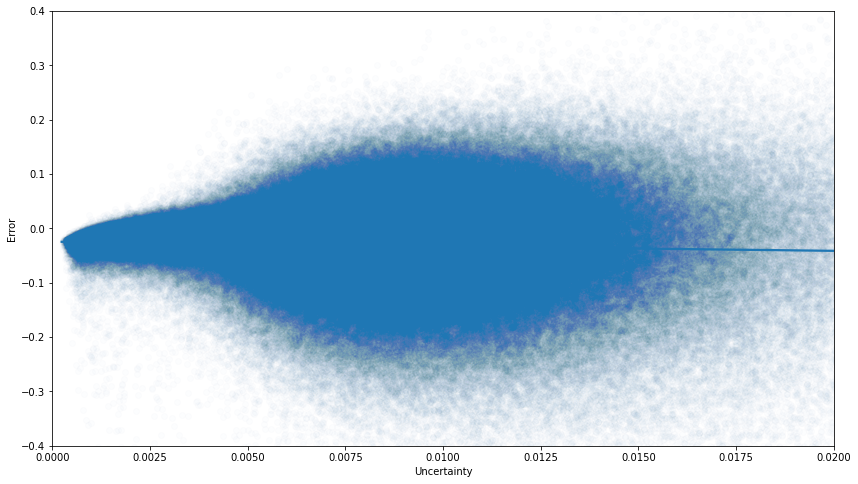

In [6]:
sns.regplot(x = "Uncertainty", y = "Error", data = plot_df.iloc[::10], scatter_kws={"alpha": 0.01})
plt.xlim([0, 0.02])
plt.ylim([-0.4, 0.4])

<AxesSubplot:xlabel='Is_inside', ylabel='Uncertainty'>

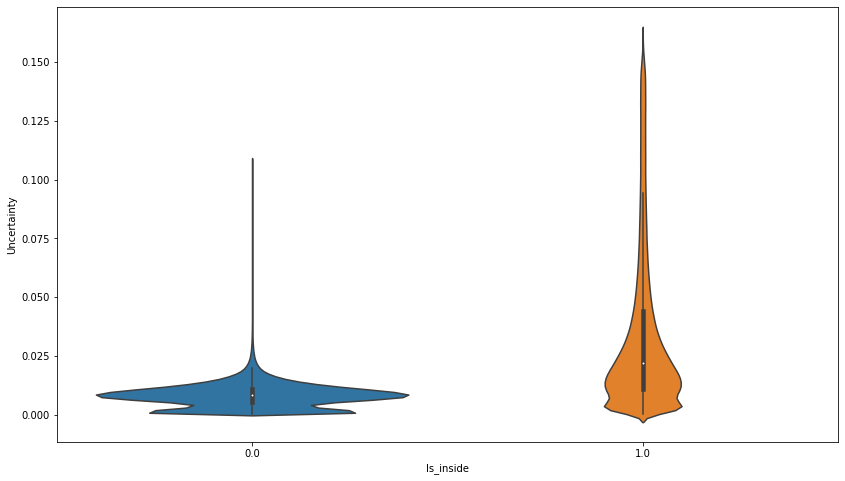

In [19]:
sns.violinplot(x = "Is_inside", y = "Uncertainty", data = plot_df)

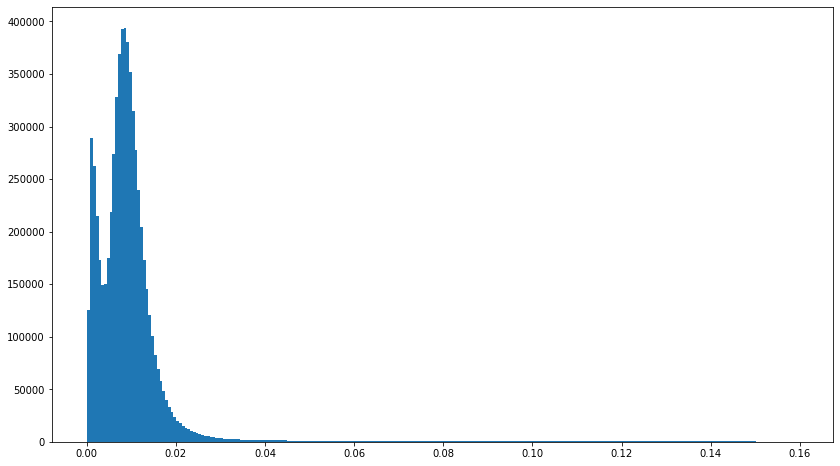

In [12]:
_ = plt.hist(gather_uncertainty, bins=256)